# Follow-up of GW events with an IACT

Marcos Santander - Univ. of Alabama (jmsantander@ua.edu)

ISAPP 2022 - https://indico.ijclab.in2p3.fr/event/7633/

## Goals, requirements, and additional material

#### Goals for this excercise

As in other cases, in the interest of time, the ideas shown here have been simplified so that they can be explained briefly in a single notebook. The goals for this excercise are to:

* Become familiarized with the tools available to get and plot GW event skymaps. 
* Calculate a rudimentary tiling for an event assuming a given field of view for our telescope.
* Check the visibility of the event region and for moon and sun constraints.
* Derive a basic tiling ranking optimizing for total slewing time and probability coverage.
* Use galaxy catalogs and the GW distance estimate to improve our chances of detecting a counterpart.

#### Required libraries

This notebook makes extensive use of the `ligo.skymap` library. Beyond installing it I recommend taking a look at the documentation [here](https://lscsoft.docs.ligo.org/ligo.skymap/index.html).

The basic libraries used here that we've used before are `matplotlib`, `numpy`, `astropy`, `healpy`, `urllib3`. New libraries include: `astroplan`, `astroquery` and `tsp_solver2`

We can install all by running:

`pip install ligo.skymap matplotlib numpy astropy healpy urllib3 astroplan astroquery tsp_solver2`

#### Additional material

All current IACTs operate GW follow-up programs. The first follow-up of a GW event from a binary neutron star (BNS) merger was performed by [HESS for GW170817](https://arxiv.org/abs/1710.05862) so we recommend looking at that paper and the algorithms cited for a fully-worked example.  

In general, the approach followed by most EM observatories is based on the paper ["Going the Distance: Mapping Host Galaxies of LIGO and Virgo Sources in Three Dimensions Using Local Cosmography and Targeted Follow-up
" by Singer et al.](https://arxiv.org/abs/1603.07333) that takes into account the localization probability of the GW event, the distance estimates, and can also use a galaxy catalog.

In [2]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
import operator
import sys
import pylab as pl
import healpy as hp
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import astroplan

import ligo.skymap.plot
from ligo.skymap.plot import mellinger
from ligo.skymap.postprocess import contour
from ligo.skymap import postprocess

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import astropy.coordinates
import astropy.time
import astropy.units as u

degree = np.pi / 180
pl.rcParams['font.size'] = 14

## 1) Getting the GW localization maps

The discovery of GW170817 in coincidence with the short GRB 170817A showed that at least some short GRBs must be produced in the merger of binary neutron star systems. IACTs have also recently detected VHE gamma-ray emission from long GRBs, and there's at least one case of evidence for VHE emission associated with a short GRB, which makes IACT good follow-up instruments to localize the EM counterparts to GW events.

The maing challenges are the rapid response needed (as VHE gammas are mostly expected in the prompt phase) and the large localization uncertainties, which must be tiled in order to cover at least a fraction of the total localization probability map.

LIGO/Virgo circulate rapid localization maps for their GW alerts, including BNS mergers. In December 2022 it is expected that LIGO/Virgo/KAGRA will start their 4th science run (O4) enabling new follow-ups.

In [3]:
# Degrade resolution while maintaining the probability density (healpy ud_grade averages pixel values)
def ud_grade_prob(hmap, nside_out):
    nside_in = hp.get_nside(hmap)
    return hp.ud_grade(hmap,nside_out=nside_out)*(nside_in/nside_out)**2


# Build a binary mask for a containment level. 
def getCLMaskMap(hmap, cl=0.9):
    mask = np.zeros(len(hmap))

    t = enumerate(hmap)
    sortedlist = np.array(sorted(t, key=operator.itemgetter(1), reverse=True))
    cumsum = np.cumsum(sortedlist[:,1])

    index=(i for i,v in enumerate(cumsum) if v > cl).__next__()
    mask_pixids = sortedlist[:,0][0:index]

    for i in sortedlist[:,0][0:index]:
        mask[int(i)] = 1

    return mask

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

Let's use the map for GW170817. This is the *initial* map (from the BAYESTAR pipeline) distributed shortly after the detection of the event, not the one used in the final publication. The information is available here: https://dcc.ligo.org/LIGO-G1701985/public

In [4]:
# For memory usage reasons I have switched to a lower resolution version (Nside=256), but use the one below otherwise. 
#bayestar_map = "https://dcc.ligo.org/public/0146/G1701985/001/bayestar.fits.gz"

bayestar_map = "http://nevis.columbia.edu/~santander/bayestar_256.fits"

mapfilename = bayestar_map.split('/')[-1]
data = urllib.request.urlretrieve(bayestar_map, mapfilename)

# Read HealPIX map
hmap_base = hp.read_map(mapfilename)

The map below shows the source localization probability per pixel in equatorial coordinates.

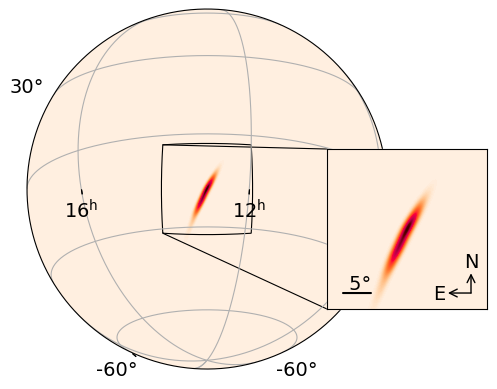

In [5]:
# Centroid according to GCN Circular #21513 https://gcn.gsfc.nasa.gov/gcn3/21513.gcn3
    
centroid = SkyCoord('12h57m', '-17d51m', frame='icrs')

fig = pl.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=centroid)

ax_inset = plt.axes(
    [0.7, 0.2, 0.6, 0.4],
    projection='astro zoom',
    center=centroid,
    radius=15*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx(hmap_base, cmap='cylon')
ax_inset.imshow_hpx(hmap_base, cmap='cylon')


# 2) Tiling the error region of the GW event

Beyond the short response time, the main goals for a follow-up is to cover the most localization probability in the least amount possible. The field of view of our telescope will determine the solid angle we can cover in a single pointing, and will most likely require tiling the event region to cover a certain amount of probability.

Since this GW event occured in the Southern sky, we will use H.E.S.S. for our follow up. The H.E.S.S. 12-m telescopes have a field of view of 5 deg. 

There are multiple algorithms to tile regions to match the FoV of a particular telescope. In this example, for simplicity, we will use the underlying HEALPix equal-area grid. We select an `Nside = 16`, which provides pixels with ~3.7$^{\circ}$ spacing which are a good fit for the 5$^{\circ}$ FoV of H.E.S.S. plus some overlap. Each pointing will be provided by the centroid of the pixel that is above a certain threshold in probability.

In [6]:
# The average angular size of the pixels 
hp.pixelfunc.nside2resol(16) / degree

3.6645188392718997

In [7]:
# Degrade the resolution of the map from Nside = 512 (~0.1 deg spacing) to Nside = 16 (~3.7 deg spacing)
# This is included in the mask generation so no need to do it here
out_nside = 16
hmap_ud = ud_grade_prob(hmap_base, out_nside)

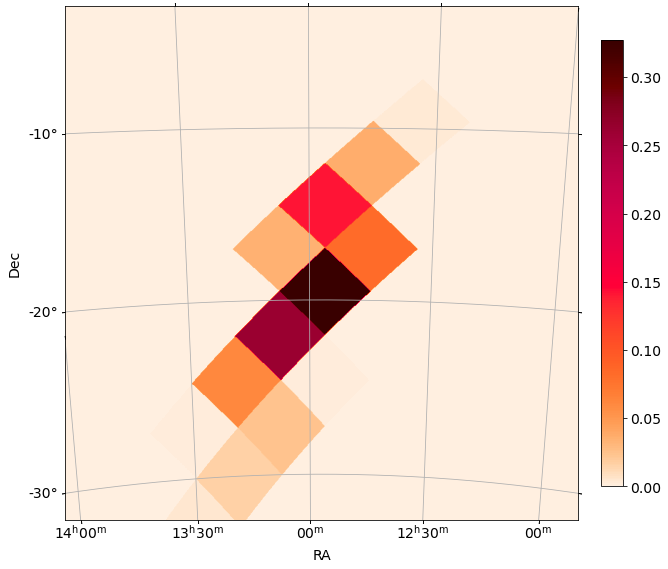

In [8]:
fig = pl.figure(figsize=(10,10))
ax = pl.axes(projection='astro zoom',
              center=centroid, radius='15 deg')
ax.grid()
s = ax.imshow_hpx(hmap_ud, cmap='cylon', order='nearest-neighbor')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

pl.colorbar(s, fraction=0.04, pad=0.04)

How many pointings do we need?

In [9]:
sortedMap = np.sort(hmap_ud)
s = [np.sum(sortedMap[::-1][0:i]) for i in range(len(hmap_ud))]

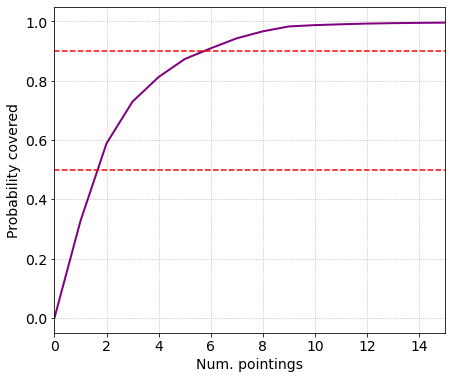

In [10]:
pl.figure(figsize=(7,6))
pl.plot(range(len(s)),s, color='purple', linewidth=2)
pl.xlim(0,15)
pl.axhline(0.5, color='red', linestyle='--')
pl.axhline(0.9, color='red', linestyle='--')

pl.xlabel("Num. pointings")
pl.ylabel("Probability covered")
pl.grid(linestyle=':')

With only 2 pointings we can cover 50% of the localization probability, and with 6 we can cover 90%. Let's go for 6 pointings, so we need the 6 hottest pixels in our map.

In [11]:
# Probability covered in the 6 hottest pixels
nhotpix = 6
hotpix_vals = sortedMap[::-1][:nhotpix]
cov_prob = np.sum(sortedMap[::-1][:nhotpix])
print(np.round(cov_prob,3))

0.909


In [12]:
# Probability threshold
p_thresh = hotpix_vals[-1]

# Pix IDs for those above threshold 

hotpix_ids = np.arange(len(hmap_ud))[hmap_ud >= p_thresh]

In [13]:
ra_point, dec_point = hp.pix2ang(out_nside, hotpix_ids, lonlat=True)
prob_point = hmap_ud[hotpix_ids]

import pandas as pd

df = pd.DataFrame(list(zip(ra_point, dec_point, prob_point)),
               columns =['ra', 'dec', 'prob'])

df_sorted = df.sort_values('prob', ascending=False, ignore_index = True)

df_sorted

ra        dec      prob
0  194.0625 -19.471221  0.327334
1  196.8750 -22.024313  0.261423
2  194.0625 -14.477512  0.141102
3  191.2500 -16.957763  0.082727
4  199.6875 -24.624318  0.060530
5  191.2500 -12.024699  0.036250

Text(197.448711984, -23.38397612351, 'NGC 4993')

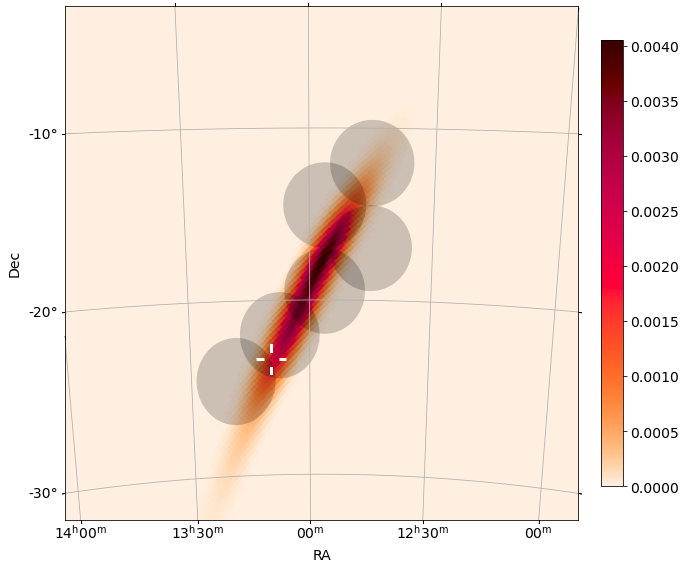

In [14]:
fig = pl.figure(figsize=(10,10))
ax = pl.axes(projection='astro zoom',
              center=centroid, radius='15 deg')
ax.grid()
s = ax.imshow_hpx(hmap_base, cmap='cylon', order='nearest-neighbor')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

pl.colorbar(s, fraction=0.04, pad=0.04)

from matplotlib.patches import Circle

for index, row in df_sorted.iterrows():
    
    c = Circle((row['ra'], row['dec']), 2.5, edgecolor='black', facecolor='black', linewidth=0, alpha=0.2,
           transform=ax.get_transform('fk5'))
    
    ax.add_patch(c)
    
ngc4993 = SkyCoord.from_name('NGC 4993')

ax.plot(
    ngc4993.ra.deg, ngc4993.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3, color='white')

ax.annotate("NGC 4993", (ngc4993.ra.deg, ngc4993.dec.deg), xycoords='data', 
            transform=ax.get_transform('world'), color='blue')

Let's compare this to the actual tiling done by H.E.S.S. during their follow-up of GW170817. https://arxiv.org/abs/1710.05862

The skymap below shows the first pointings on the night of Aug 17th (in gray), followed by a monitoring campaign on NGC 4993 the next night once the optical kilonova was identified (in blue). The position of NGC 4993 is indicated.

Text(197.448711984, -23.38397612351, 'NGC 4993')

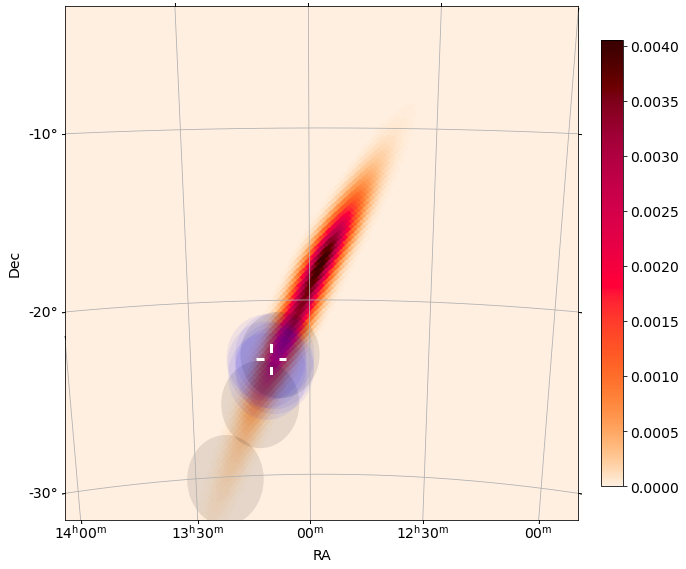

In [15]:
fig = pl.figure(figsize=(10,10))

ngc4993 = SkyCoord.from_name('NGC 4993')

ax = pl.axes(projection='astro zoom',
              center=centroid, radius='15 deg')
ax.grid()
s = ax.imshow_hpx(hmap_base, cmap='cylon', order='nearest-neighbor')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

pl.colorbar(s, fraction=0.04, pad=0.04)

from matplotlib.patches import Circle

ra_hess = [196.88, 198.19, 200.57]
dec_hess = [-23.17, -25.98, -30.15]

ra_ngc = [197.75, 197.23, 197.21, 197.71, 197.24, 197.70]
dec_ngc = [-23.31, -23.79, -23.20, -23.71, -24.07, -24.38]

for (r,d) in zip(ra_hess, dec_hess):
    
    c = Circle((r, d), 2.5, edgecolor='black', facecolor='black', linewidth=0, alpha=0.1,
           transform=ax.get_transform('fk5'))
    
    ax.add_patch(c)
    
for (r,d) in zip(ra_ngc, dec_ngc):
    
    c = Circle((r, d), 2.5, edgecolor='black', facecolor='blue', linewidth=0, alpha=0.06,
           transform=ax.get_transform('fk5'))
    
    ax.add_patch(c)
    

ax.plot(
    ngc4993.ra.deg, ngc4993.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3, color='white')

ax.annotate("NGC 4993", (ngc4993.ra.deg, ngc4993.dec.deg), xycoords='data', 
            transform=ax.get_transform('world'), color='blue')

This is a pretty straightforward tiling given how small the localization uncertainty is, but typical GW events have much larger error regions so we need to consider two additional things:
    
* Visibility to different parts of the sky map.
* Ranking the different tiles to minimize the total slewing time.
* Prioritizing regions that have potential host galaxies within the LIGO horizon.

## 3) Visibility considerations

Was the GW event position observable at the time of the event? The coalescence time was 12:41:04.4 UTC, with the first notice being sent at 13:21 UTC and the first map including both LIGO detectors and Virgo, whe one we have used so far, at 17:54:51 UTC. Let's see if that region of the sky was observable from H.E.S.S. at the time of receipt of the LVC updated localization map. 

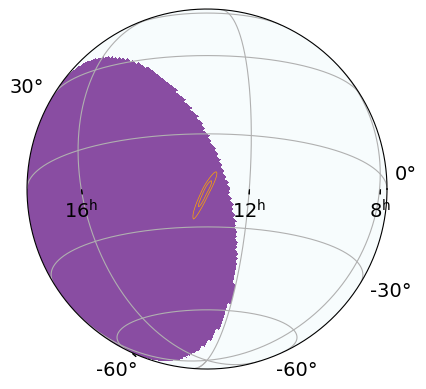

In [16]:
gwtime_circ = astropy.time.Time("2017-08-17 17:54:51", format='iso', scale='utc')
hesslat=-(23+16/60.+17/3600.)
hesslng=16.5

hesspos = astropy.coordinates.EarthLocation(lat=hesslat*u.deg, lon=hesslng*u.deg, height=1800*u.m)

nside_vis = 64
ra, dec = hp.pix2ang(nside_vis, np.arange(hp.nside2npix(nside_vis)), lonlat=True) 
radecs = astropy.coordinates.SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

frame = astropy.coordinates.AltAz(obstime=gwtime_circ, location=hesspos)
altaz = radecs.transform_to(frame)

# We'll define positions above 30 deg elevation as "observable"
obspoints = altaz.alt > 30 * u.deg

centroid = SkyCoord('12h57m', '-17d51m', frame='icrs')

fig = pl.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=centroid)

ax.grid()
ax.imshow_hpx(obspoints, cmap='BuPu', vmax=1.4, order='nearest-neighbor')

cls = 100 * postprocess.find_greedy_credible_levels(hmap_base)

# Let's draw the 50% and 90% containment contours for the GW event
cs = ax.contour_hpx(
            (cls, 'ICRS'), colors='orange', linewidths=0.5, levels=[50, 90])

The entire localization region was observable (in this case meaning, above 30 deg elevation) at the time the updated skymap was received but quickly setting near the edge of the observability window. And more importantly, is it day or night? :)

In [17]:
from astropy.coordinates import get_sun

sun = get_sun(gwtime_circ)
altaz_sun = sun.transform_to(frame)

print(np.round(altaz_sun.alt.deg,2), "deg")

-18.05 deg


The Sun is more than 18 deg below the horizon, so we're beyond the astronomical twilight and the sky should be dark enough to observe. The moon can also interfere with IACT observations, where is it?

In [18]:
from astropy.coordinates import get_moon

moon = get_moon(gwtime_circ)
altaz_moon = moon.transform_to(frame)

print(np.round(altaz_moon.alt.deg,2), "deg")

-71.64 deg


Good! no moon. What if we had had a larger error region that would take longer to tile. Starting on the time of the GCN circular, let's look at how much time we had to observe that night until the morning astronomical twilight.

In [19]:
def getNextTwilight(pos, t0 = astropy.time.Time.now()):
    obs = astroplan.Observer(location=pos,timezone='UTC')
    is_night = obs.is_night(t0,horizon=-18 * u.degree)

    if is_night:
        ti = t0
        tf = obs.twilight_morning_astronomical(t0,which='next')
    
    else:
        ti = obs.twilight_evening_astronomical(t0,which='next')
        tf = obs.twilight_morning_astronomical(ti,which='next')
    
    return (ti,tf)

In [20]:
nside = 32
npix = hp.nside2npix(nside)
mvis = np.zeros(npix)
ntimes = 200

# Let's define anything above 30 deg elevation as observable.
elevcut = 30 * u.deg

tstart, tend = getNextTwilight(hesspos, gwtime_circ)
dt = 24 * (tend.mjd - tstart.mjd)/ntimes

mjds = np.linspace(tstart.mjd, tend.mjd, ntimes)
ra, dec = hp.pix2ang(nside, np.arange(npix), lonlat=True)
radecs = astropy.coordinates.SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

for mjd in mjds:
    t = astropy.time.Time(mjd, format='mjd')
    frame = astropy.coordinates.AltAz(obstime=t, location=hesspos)
    altaz = radecs.transform_to(frame)
    dts = (altaz.alt > elevcut) * dt
    
    sun_altaz = astropy.coordinates.get_sun(t).transform_to(altaz)
    
    if sun_altaz.alt <= -18*u.deg:
        mvis = dts + mvis

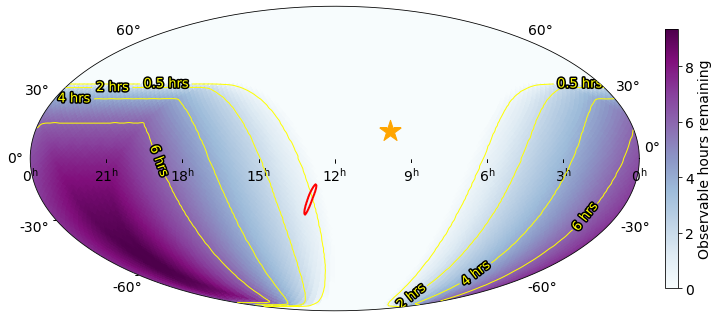

In [21]:
import matplotlib.patheffects as PathEffects

from astropy.coordinates import get_sun, get_moon
from astropy.coordinates import EarthLocation
from astropy.time import Time

fig = plt.figure(figsize=(10,6))
        
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro mollweide')
        
# Let's draw the 50% and 90% containment contours for the GW event
visplot = ax.imshow_hpx(mvis, cmap='BuPu', order='nearest-neighbor')

cs = ax.contour_hpx((mvis, 'ICRS'), colors='yellow', linewidths=1, levels=[0.5, 2, 4, 6])

fmt = r'%g hrs' 
for text in plt.clabel(cs, fmt=fmt, inline=True, fontsize=13):
    text.set_path_effects(path_effects=[PathEffects.withStroke(linewidth=3, foreground="black")])

# 90% containment region for the GW event
cs = ax.contour_hpx(
            (cls, 'ICRS'), colors='red', linewidths=2, levels=[90])

sun = get_sun(gwtime_circ)

ax.scatter(sun.ra.deg, sun.dec.deg, marker='*', s=500, 
    transform=ax.get_transform('world'), color='orange')

cb = plt.colorbar(visplot, fraction=0.02, pad=0.04)
cb.set_label('Observable hours remaining')


This map shows the number of observable hours starting from the time of the circular up until the morning twilight above 30 deg elevation. The 90% localization region is shown in red and the sun is the orange star.

Let's now plot the elevation of the centroid of the GW event vs time.

In [22]:
sites = {
    'VERITAS' :  EarthLocation.of_site('Whipple'),
    'MAGIC' : EarthLocation.of_site('Roque de los Muchachos'),
    'HESS' : EarthLocation(lon=16.5019*u.deg, lat=-23.2713*u.deg, height=100*u.m),
    'HAWC' : EarthLocation(lon=-97*u.deg, lat=19*u.deg, height=4100*u.m)
}

In [23]:
class VisibilityPlot:
    def __init__(self, site, target, targetName="", tref = Time.now(), tevent=None, hstart=-4, hend=36):
        self.fig = pl.figure(figsize=(10,6))
        self.ax = self.fig.add_subplot(111)
        self.dt = np.linspace(hstart, hend, 300) * u.hour
        self.tref = tref
        self.tevent = tevent

        self.t0 = Time(np.floor(self.tref.mjd), format='mjd')
        self.times = self.t0 + self.dt

        altaz_frame = astropy.coordinates.AltAz(obstime=self.times, location=site)
        sun_altaz = get_sun(self.times).transform_to(altaz_frame)
        moon_altaz = get_moon(self.times).transform_to(altaz_frame)

        #target = SkyCoord.from_name('M33')
        target_altaz = target.transform_to(altaz_frame)

        self.ax.plot(self.dt, sun_altaz.alt, color='orange', label='Sun', lw=3)
        self.ax.plot(self.dt, moon_altaz.alt, color="gray", ls='--', label='Moon', lw=3)

        self.ax.plot(self.dt, target_altaz.alt, label=targetName, color='red')

        self.ax.fill_between(self.dt.to('hr').value, 0, 90,
                 sun_altaz.alt < -0*u.deg, color='0.9', zorder=0)

        self.ax.fill_between(self.dt.to('hr').value, 0, 90,
                 sun_altaz.alt < -18*u.deg, color='0.75', zorder=0)

        self.ax.set_xlim(hstart, hend)
        self.ax.set_ylim(0,90)

        t1 = self.t0 + 1 * u.day

        self.ax.axvline(24, color='dodgerblue', lw=1, ls='--')
        self.ax.text(23.6,89, t1.iso.split(".")[0] + " UTC", rotation=90, \
                     color='dodgerblue', size=11, ha='center', va='top')

        self.ax.axvline(0, color='dodgerblue', lw=1, ls='--')
        self.ax.text(-0.4,89, self.t0.iso.split(".")[0] + " UTC", rotation=90, \
                     color='dodgerblue', size=11, ha='center', va='top')

        if tevent is not None:
            hevent = (self.tevent.mjd - self.t0.mjd) * 24.
            self.ax.axvline(hevent, color=[0.6,0.,0.], lw=1, ls='--')
            self.ax.text(hevent-0.4,89, "Event trigger: " + self.tevent.iso.split(".")[0] + " UTC", rotation=90, \
                     color=[0.6,0.,0.], size=11, ha='center', va='top', clip_on=True)

        self.ax.set_xticks(np.arange(hstart,hend,4))
        self.ax.set_xticklabels(np.arange(hstart,hend,4)%24)

        self.ax.set_xlabel('UTC Time')
        self.ax.set_ylabel('Altitude [$^{\circ}$]')

    def legend(self):
        self.ax.legend(loc='best')

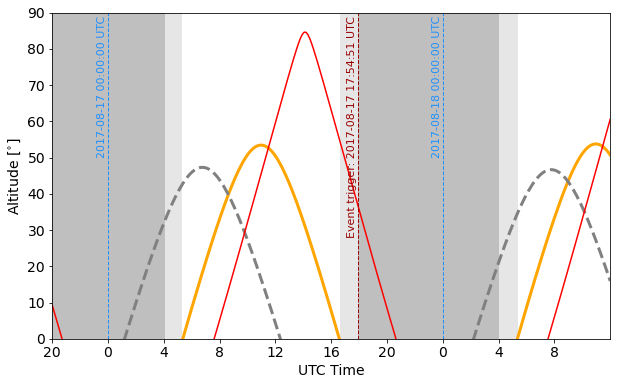

In [24]:
VisibilityPlot(sites['HESS'], centroid, "GW170817 centroid", gwtime_circ, gwtime_circ)

At the time the updated GCN Circular was posted the source (shown in red here) was setting and there was only ~1 hour to go before it dropped below 30 deg elevation. The yellow line is the sun, and gray dashed line is the moon. The gray bands indicate the dark periods between the civil (light) and astronomical (dark) twilights.

## 4) Scheduling the tiling of the GW region

For this part we will use a GW event with a considerably larger error region: the second BNS merger observed ([GW190425](https://arxiv.org/abs/2001.01761)) where the 90% credible sky area was 8284 deg$^{2}$. We will concentrate only on the tiling aspects, not on the visibility that was discussed already.

In [25]:
url_s190525z = "https://gracedb.ligo.org/api/superevents/S190425z/files/bayestar.fits.gz,0"

mapfilename = url_s190525z.split('/')[-1]
data = urllib.request.urlretrieve(url_s190525z, mapfilename)

# Read HealPIX map
hmap_s190525z = hp.read_map(mapfilename)

<a list of 4 text.Text objects>

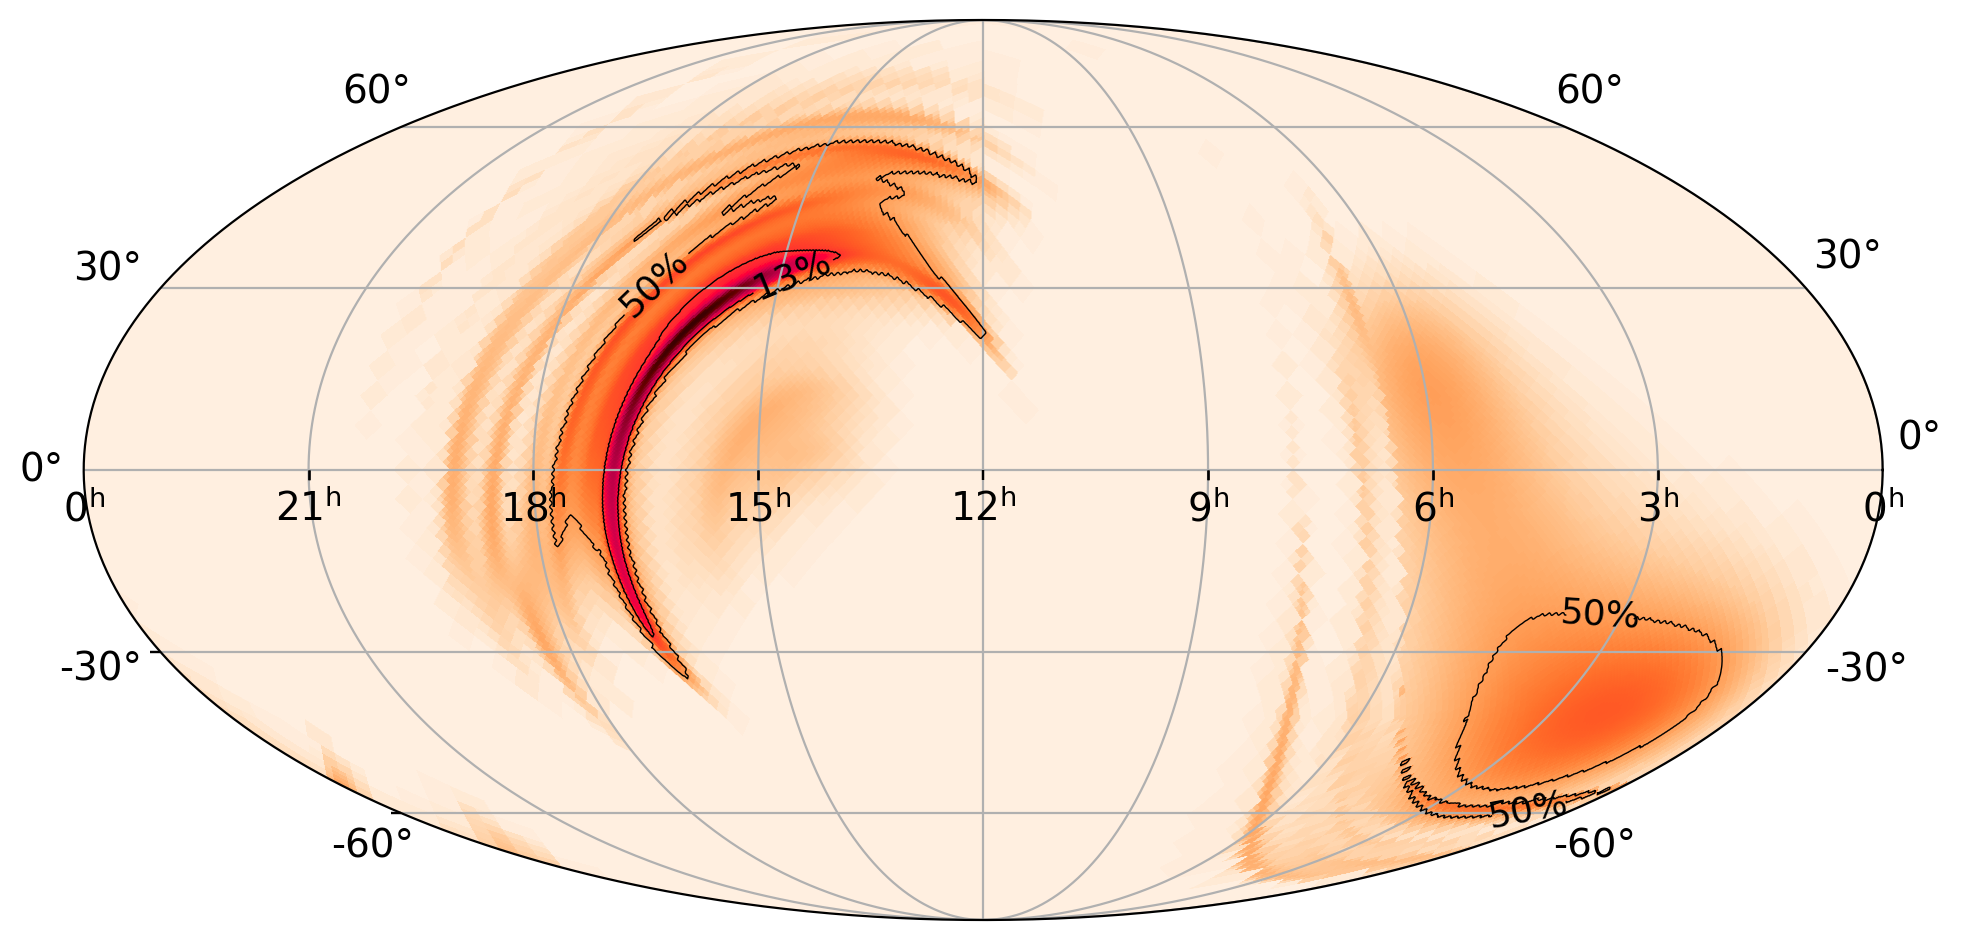

In [26]:
fig = pl.figure(figsize=(10, 5), dpi=200)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro mollweide')


ax.grid()
ax.imshow_hpx(hmap_s190525z, cmap='cylon', order='nearest-neighbor')

cls = 100 * postprocess.find_greedy_credible_levels(hmap_s190525z)

# Let's draw the 50% and 90% containment contours for the GW event
cs = ax.contour_hpx(
            (cls, 'ICRS'), colors='black', linewidths=0.5, levels=[13, 50])

fmt = r'%g%%'
plt.clabel(cs, fmt=fmt, inline=True, fontsize=13)

As seen above, the 50% region spans both hemispheres so it would be impractical to tile it completely. We will concentrate on the core 13% of the localization probability.

We'll use the same approach as before:

* Degrade the resolution of the skymap to 3.7 deg spacing.
* Ranking pixels according to their probability.
* Select the top *N* pixels that cover the probability we want to target.

In [27]:
out_nside = 16
hmap_ud_s190525z = ud_grade_prob(hmap_s190525z, out_nside)

In [28]:
sortedMap = np.sort(hmap_ud_s190525z)
s = [np.sum(sortedMap[::-1][0:i]) for i in range(len(hmap_ud_s190525z))]

# Let's do 29 pointings which should give us 13.7% coverage
nhotpix = 29
hotpix_vals = sortedMap[::-1][:nhotpix]
cov_prob = np.sum(sortedMap[::-1][:nhotpix])
print("Probability covered by 29 pointings:", np.round(cov_prob,3))

Probability covered by 29 pointings: 0.137


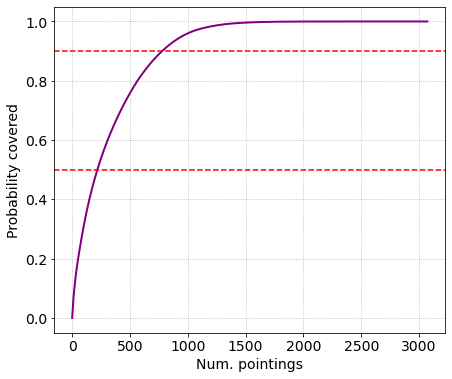

In [29]:
# Getting to 90% would take hundreds of pointings

pl.figure(figsize=(7,6))
pl.plot(range(len(s)),s, color='purple', linewidth=2)
pl.axhline(0.5, color='red', linestyle='--')
pl.axhline(0.9, color='red', linestyle='--')

pl.xlabel("Num. pointings")
pl.ylabel("Probability covered")
pl.grid(linestyle=':')

Let's list those 29 pointings

In [30]:
p_thresh = hotpix_vals[-1]

# Pix IDs for those above threshold 
hotpix_ids = np.arange(len(hmap_ud_s190525z))[hmap_ud_s190525z >= p_thresh]
print(len(hotpix_ids))

ra_point, dec_point = hp.pix2ang(out_nside, hotpix_ids, lonlat=True)
prob_point = hmap_ud_s190525z[hotpix_ids]

df = pd.DataFrame(list(zip(ra_point, dec_point, prob_point)),
               columns =['ra', 'dec', 'prob'])

df_sorted = df.sort_values('prob', ascending=False, ignore_index = True)

df_sorted

29


ra        dec      prob
0   247.5000  16.957763  0.006866
1   244.6875  19.471221  0.006798
2   236.2500  27.279613  0.006764
3   233.4375  30.000000  0.006653
4   239.0625  24.624318  0.006423
5   241.8750  22.024313  0.006417
6   250.3125  14.477512  0.005703
7   250.3125   9.594068  0.005628
8   253.1250   7.180756  0.005494
9   230.6250  32.797168  0.005337
10  253.1250   2.388015  0.005306
11  225.0000  32.797168  0.005142
12  241.8750  27.279613  0.004256
13  222.1875  35.685335  0.004217
14  244.6875  24.624318  0.004197
15  255.9375  -4.780192  0.004183
16  253.1250  -2.388015  0.003990
17  255.9375  -9.594068  0.003927
18  239.0625  30.000000  0.003916
19  255.9375   0.000000  0.003900
20  247.5000  22.024313  0.003745
21  253.1250  12.024699  0.003725
22  227.8125  35.685335  0.003719
23  216.5625  35.685335  0.003703
24  227.8125  30.000000  0.003604
25  253.1250 -16.957763  0.003589
26  236.2500  32.797168  0.003486
27  253.1250 -22.024313  0.003469
28  250.3125  19.471221  0.003263

We will now plot them on the sky.

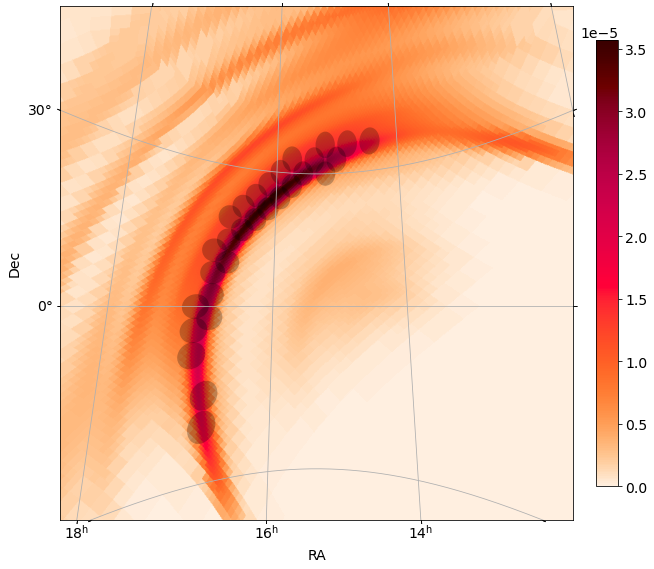

In [31]:
fig = pl.figure(figsize=(10,10))

centroid_s190525z = SkyCoord('230d', '10d', frame='icrs')

ax = pl.axes(projection='astro zoom',
              center=centroid_s190525z, radius='60 deg')
ax.grid()
s = ax.imshow_hpx(hmap_s190525z, cmap='cylon', order='nearest-neighbor')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

pl.colorbar(s, fraction=0.04, pad=0.04)

for index, row in df_sorted.iterrows():
    
    c = Circle((row['ra'], row['dec']), 2.5, edgecolor='black', facecolor='black', linewidth=0, alpha=0.25,
           transform=ax.get_transform('fk5'))
    
    ax.add_patch(c)
    


As can be seen above, these pointings are spread out over a large arc on the sky. The flux for most GRBs drops in time approximately with $\propto t^{-1}$, so covering the largest probability fraction (i.e. visiting the most positions possible) in the least time is of the essence.

Beyond the time spend observing, there's also an overhead for the telescopes to slew from one pointing to the next (we can assume 1 deg/sec for current generation instruments), so while we need to prioritize covering the most probability we should also account for the total time spent slewing.

This is a type of [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) which can be solved by multiple algorithms. The solution typically involves calculating a cost function for going from one position to the next and minimizing the total cost of the trip to visit each position. We'll be using the [tsp_solver2](https://github.com/dmishin/tsp-solver) library.

In [32]:
from tsp_solver.greedy import solve_tsp
from tsp_solver.util import path_cost

Ignoring visibility and sensitivity contraints we will estimate the cost based on two quantities, the probability jump between one pointing and the next (`getProbDistance`) and the great-circle distance between both pointings (`greatCircleDistance`).

In [33]:
def greatCicleDistance(p1, p2):
    ra1 = p1[0] * degree
    dec1 = p1[1] * degree
    
    ra2 = p2[0] * degree
    dec2 = p2[1] * degree
    
    
    x1 = np.cos(dec1) * np.cos(ra1)
    y1 = np.cos(dec1) * np.sin(ra1)
    z1 = np.sin(dec1)
    
    x2 = np.cos(dec2) * np.cos(ra2)
    y2 = np.cos(dec2) * np.sin(ra2)
    z2 = np.sin(dec2)
    
    sprod = x1*x2 + y1*y2 + z1*z2
    
    return np.arccos(sprod) / degree

def getProbDistance(p1, p2):
    return np.abs(p1[2] - p2[2])

# the weighted "distance" to first order is the actual angular distance between two pointings, 
# but one could add different weightings to include probability differences, visibility, etc. 

def getWeightedDistance(p1,p2,powdist=1,powprob=1):
    '''
    powdist: power of the angular distance weight. 
    powprob: power of the probability distance weight. 
    '''
    return greatCicleDistance(p1, p2)**powdist * getProbDistance(p1,p2)**powprob

def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return np.array(z) 

We'll first calculate the path only minimizing the slewing time between points (`powdist = 1` and `powprob=0` in `getWeightedDistance()`).

In [34]:
npoints = 29

pointings = df_sorted.to_numpy()

# This calculates a triangular matrix of Npoints x Npoints with the great-circle distances between each pointing    
dm = np.asarray([[getWeightedDistance(p1, p2, 1, 0) for p2 in pointings] for p1 in pointings])

for i in np.arange(npoints):
    dm[i,i] = 0

order = solve_tsp(dm)

# this is the distance of the path, if we were to select just the distances for a weight this 
# is just the total angular distance. As we steer at 1 deg / sec this is ~ the time overhead in seconds 

print("Path cost:", path_cost(dm, order)) 

Path cost: 121.10498825793137


<ipython-input-33-1c23a92cf889>:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(sprod) / degree


Text(0, 0.5, 'Dec')

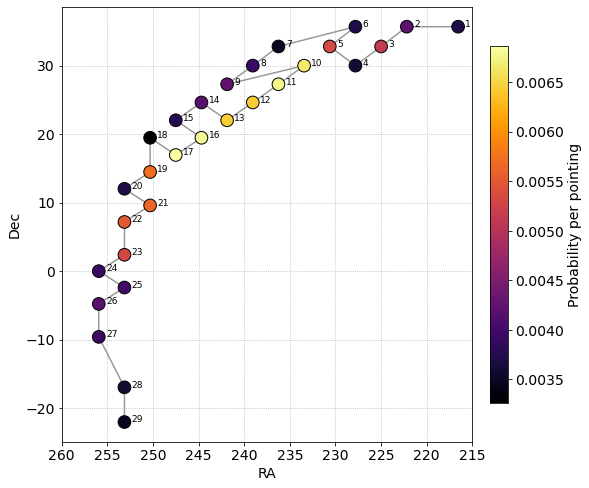

In [35]:
pl.figure(figsize=(8,8))
pl.plot(pointings[order][:,0], pointings[order][:,1], color='gray',alpha=0.8)
cpoint = pl.scatter(pointings[order][:,0], pointings[order][:,1], c=pointings[order][:,2], 
           s=160,zorder=6, edgecolor='k', cmap=pl.get_cmap('inferno'))

i = 1
for (r,d) in zip(pointings[order][:,0], pointings[order][:,1]):
    pl.annotate(i, (r-0.8, d), fontsize=9)
    i += 1
    
cb = pl.colorbar(cpoint, fraction=0.04, pad=0.04)
cb.set_label('Probability per pointing')

    
pl.grid(linestyle=":")
pl.xlim(260,215)
pl.xlabel('RA')
pl.ylabel('Dec')

As expected, we get pointings that jump from one to the nearest one to minimize the total slewing time. Let's now do just probabilities (`powdist = 0` and `powprob=1` in `getWeightedDistance()`).

<ipython-input-33-1c23a92cf889>:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(sprod) / degree


Text(0, 0.5, 'Dec')

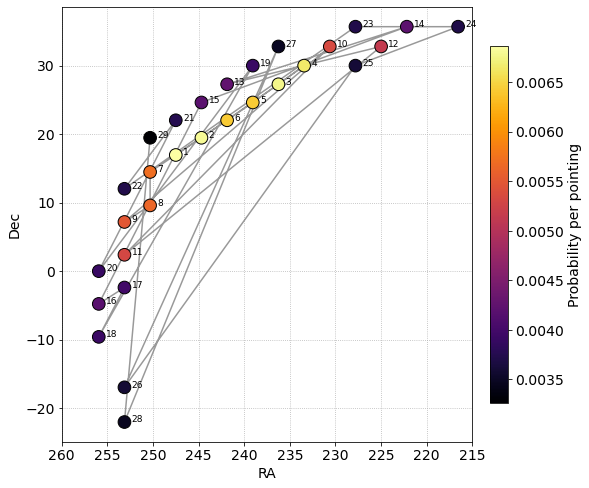

In [36]:
dm = np.asarray([[getWeightedDistance(p1, p2, 0, 1) for p2 in pointings] for p1 in pointings])

for i in np.arange(npoints):
    dm[i,i] = 0

order = solve_tsp(dm)

pl.figure(figsize=(8,8))
pl.plot(pointings[order][:,0], pointings[order][:,1], color='gray',alpha=0.8)
cpoint = pl.scatter(pointings[order][:,0], pointings[order][:,1], c=pointings[order][:,2], 
           s=160,zorder=6, edgecolor='k', cmap=pl.get_cmap('inferno'))

i = 1
for (r,d) in zip(pointings[order][:,0], pointings[order][:,1]):
    pl.annotate(i, (r-0.8, d), fontsize=9)
    i += 1
    
cb = pl.colorbar(cpoint, fraction=0.04, pad=0.04)
cb.set_label('Probability per pointing')

    
pl.grid(linestyle=":")
pl.xlim(260,215)
pl.xlabel('RA')
pl.ylabel('Dec')

There are now long jumps, but the tiling starts from the pointing with highest probability and continues down until the one with the lowest. Let's try a more balanced approach (`powdist = 1` and `powprob=1.5`) although the actual weighting would have to undergo some optimization.

Play around a bit to see what works better.

<ipython-input-33-1c23a92cf889>:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(sprod) / degree


Text(0, 0.5, 'Dec')

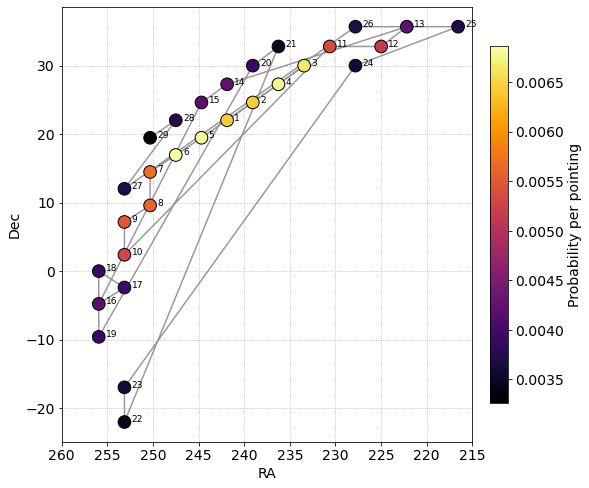

In [37]:
dm = np.asarray([[getWeightedDistance(p1, p2, 1, 1.5) for p2 in pointings] for p1 in pointings])

for i in np.arange(npoints):
    dm[i,i] = 0

order = solve_tsp(dm)

pl.figure(figsize=(8,8))
pl.plot(pointings[order][:,0], pointings[order][:,1], color='gray',alpha=0.8)
cpoint = pl.scatter(pointings[order][:,0], pointings[order][:,1], c=pointings[order][:,2], 
           s=160,zorder=6, edgecolor='k', cmap=pl.get_cmap('inferno'))

i = 1
for (r,d) in zip(pointings[order][:,0], pointings[order][:,1]):
    pl.annotate(i, (r-0.8, d), fontsize=9)
    i += 1
    
cb = pl.colorbar(cpoint, fraction=0.04, pad=0.04)
cb.set_label('Probability per pointing')

    
pl.grid(linestyle=":")
pl.xlim(260,215)
pl.xlabel('RA')
pl.ylabel('Dec')

## 5) Using a galaxy catalog

Current GW detectors have a *horizon* for BNS mergers of around 130 Mpc, so we can use galaxy surveys to look for parts of the skymap that contain galaxies within that volume. A current catalog to perform this search is the [GLADE+](http://glade.elte.hu/) catalog, with about 25 million galaxies, but given the size of the files involved let's use a smaller catalog for this example. We'll use the [GWGC catalog](https://vizier.u-strasbg.fr/viz-bin/VizieR-2) which contains 53312 entries.

In [38]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = 9999999

catalog_list = Vizier.find_catalogs('GWGC')
catalogs = Vizier.get_catalogs(catalog_list.keys())

In [39]:
catalogs[0]

<Table length=53312>
  PGC      Name   RAJ2000  DEJ2000     TT   ...   Dist   e_Dist Simbad NED  LEDA
                    deg      deg            ...   Mpc     Mpc                   
 int32    str28   float64  float64  float32 ... float32 float32  str6  str3 str4
------- --------- -------- -------- ------- ... ------- ------- ------ ---- ----
      2  UGC12889   0.0070  47.2745     3.1 ...   72.46   10.87 Simbad  NED LEDA
      4 PGC000004   0.0144  23.0876     5.0 ...   63.26   13.92 Simbad  NED LEDA
      6 PGC000006   0.0087  15.8817    -1.0 ...   84.18   18.52 Simbad  NED LEDA
      7 PGC000007   0.0183  -0.0833    -3.2 ...   97.35   21.42 Simbad  NED LEDA
     10 PGC000010   0.0325  -0.0406    -3.2 ...   98.25   21.61 Simbad  NED LEDA
     12 PGC000012   0.0360  -6.3739     1.1 ...   92.15   13.82 Simbad  NED LEDA
     13 PGC000013   0.0555  33.1342      -- ...   72.72   10.91 Simbad  NED LEDA
     16 PGC000016   0.0471  -5.1587     1.2 ...   79.28   11.89 Simbad  NED LEDA
     18 PGC000018   0.0540  46.9651      -- ...   77.31   11.60 Simbad  NED LEDA
    ...       ...      ...      ...     ... ...     ...     ...    ...  ...  ...
2802697   NGC6864 301.5195 -21.9214    -9.0 ...    0.02      -- Simbad  NED LEDA
2802698   NGC6934 308.5470   7.4042    -9.0 ...    0.02      -- Simbad  NED LEDA
2802699   NGC6981 313.3650 -12.5369    -9.0 ...    0.02      -- Simbad  NED LEDA
2802700   NGC7006 315.3720  16.1875    -9.0 ...    0.04      -- Simbad  NED LEDA
2802701   NGC7078 322.4925  12.1669    -9.0 ...    0.01      -- Simbad  NED LEDA
2802702   NGC7089 323.3715  -0.8231    -9.0 ...    0.01      -- Simbad  NED LEDA
2802703   NGC7099 325.0905 -23.1792    -9.0 ...    0.01      -- Simbad  NED LEDA
     --     Pal12 326.6610 -21.2508    -9.0 ...    0.02      -- Simbad  NED LEDA
     --     Pal13 346.6845  12.7719    -9.0 ...    0.03      -- Simbad  NED LEDA
     --   NGC7492 347.1105 -15.6114    -9.0 ...    0.03      -- Simbad  NED LEDA

Let's look at where these galaxies are on the sky and how much the overlap with our localization region.

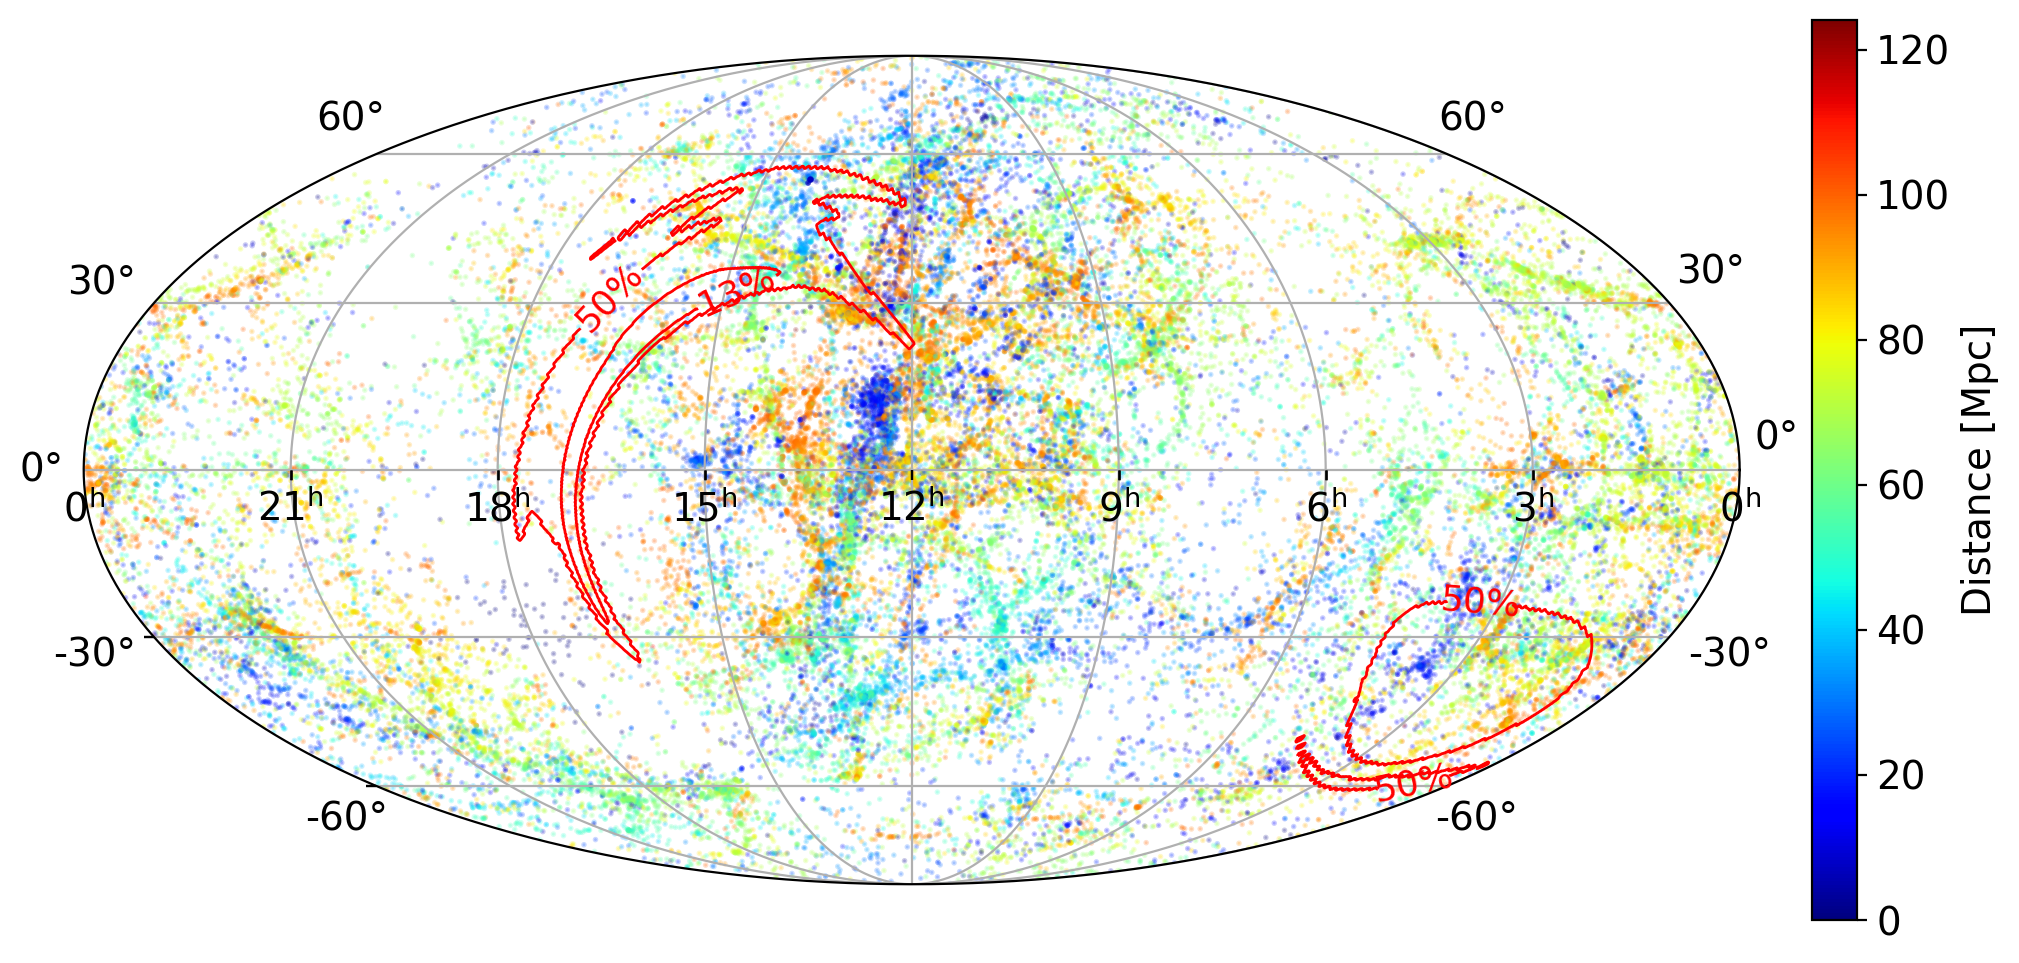

In [40]:
fig = pl.figure(figsize=(10, 5), dpi=200)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro mollweide')

galplot = ax.scatter(
    catalogs[0]['RAJ2000'], catalogs[0]['DEJ2000'],
    transform=ax.get_transform('world'),
    c=catalogs[0]['Dist'], s=1, alpha=0.2, cmap=pl.get_cmap('jet'))

cb = pl.colorbar(galplot, fraction=0.04, pad=0.04)
cb.set_alpha(1)
cb.draw_all()
cb.set_label('Distance [Mpc]')

cls = 100 * postprocess.find_greedy_credible_levels(hmap_s190525z)

# Let's draw the 50% and 90% containment contours for the GW event
cs = ax.contour_hpx(
            (cls, 'ICRS'), colors='red', linewidths=1, levels=[13, 50])

fmt = r'%g%%'
plt.clabel(cs, fmt=fmt, inline=True, fontsize=13)


ax.grid()


The distance to the merger reported in the [paper](https://arxiv.org/abs/2001.01761) is $159^{+69}_{-71}$ Mpc, so mostly beyond the coverage of our catalog. Let's anyway try to find the best candidate galaxies by folding the catalog with the sky localization and distance posteriors and rank the resulting sources. This functionality is provided by the `crossmatch()` method of the `ligo.skymap` library.

In [41]:
from astroquery.vizier import VizierClass
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import crossmatch

In [42]:
url = 'https://gracedb.ligo.org/api/superevents/S190425z/files/gw190425z_skymap.multiorder.fits,0'
skymap = read_sky_map(url, moc=True)

In [43]:
coordinates = SkyCoord(catalogs[0]['RAJ2000'], catalogs[0]['DEJ2000'], catalogs[0]['Dist'])
result = crossmatch(skymap, coordinates)

Let's restrict the searched probability volume to 13% as we did in the previous case.

In [44]:
print(catalogs[0][result.searched_prob_vol < 0.13])

  PGC            Name          RAJ2000  DEJ2000   TT  ... e_Dist Simbad NED LEDA
                                 deg      deg         ...  Mpc                  
------- ---------------------- -------- -------- ---- ... ------ ------ --- ----
  57540             ESO451-017 243.4224 -31.3640 -1.0 ...  12.30 Simbad NED LEDA
  57746                 IC4597 244.4155 -34.3659  0.0 ...   9.19 Simbad NED LEDA
  57820             ESO390-003 244.8388 -32.7186 10.0 ...  13.32 Simbad NED LEDA
  57891             ESO390-004 245.2569 -36.1422  5.0 ...   9.15 Simbad NED LEDA
  58226             ESO452-003 247.0366 -29.0968  4.0 ...   8.64 Simbad NED LEDA
  58369             ESO452-004 247.5294 -30.5465  4.0 ...   8.48 Simbad NED LEDA
  58451             ESO452-006 248.0020 -29.5546  5.0 ...  10.94 Simbad NED LEDA
  58474             ESO452-008 248.1516 -29.3850  6.7 ...  10.00 Simbad NED LEDA
  58691             ESO452-010 249.7825 -28.9822  5.0 ...  12.99 Simbad NED LEDA
  58836             ESO452-0

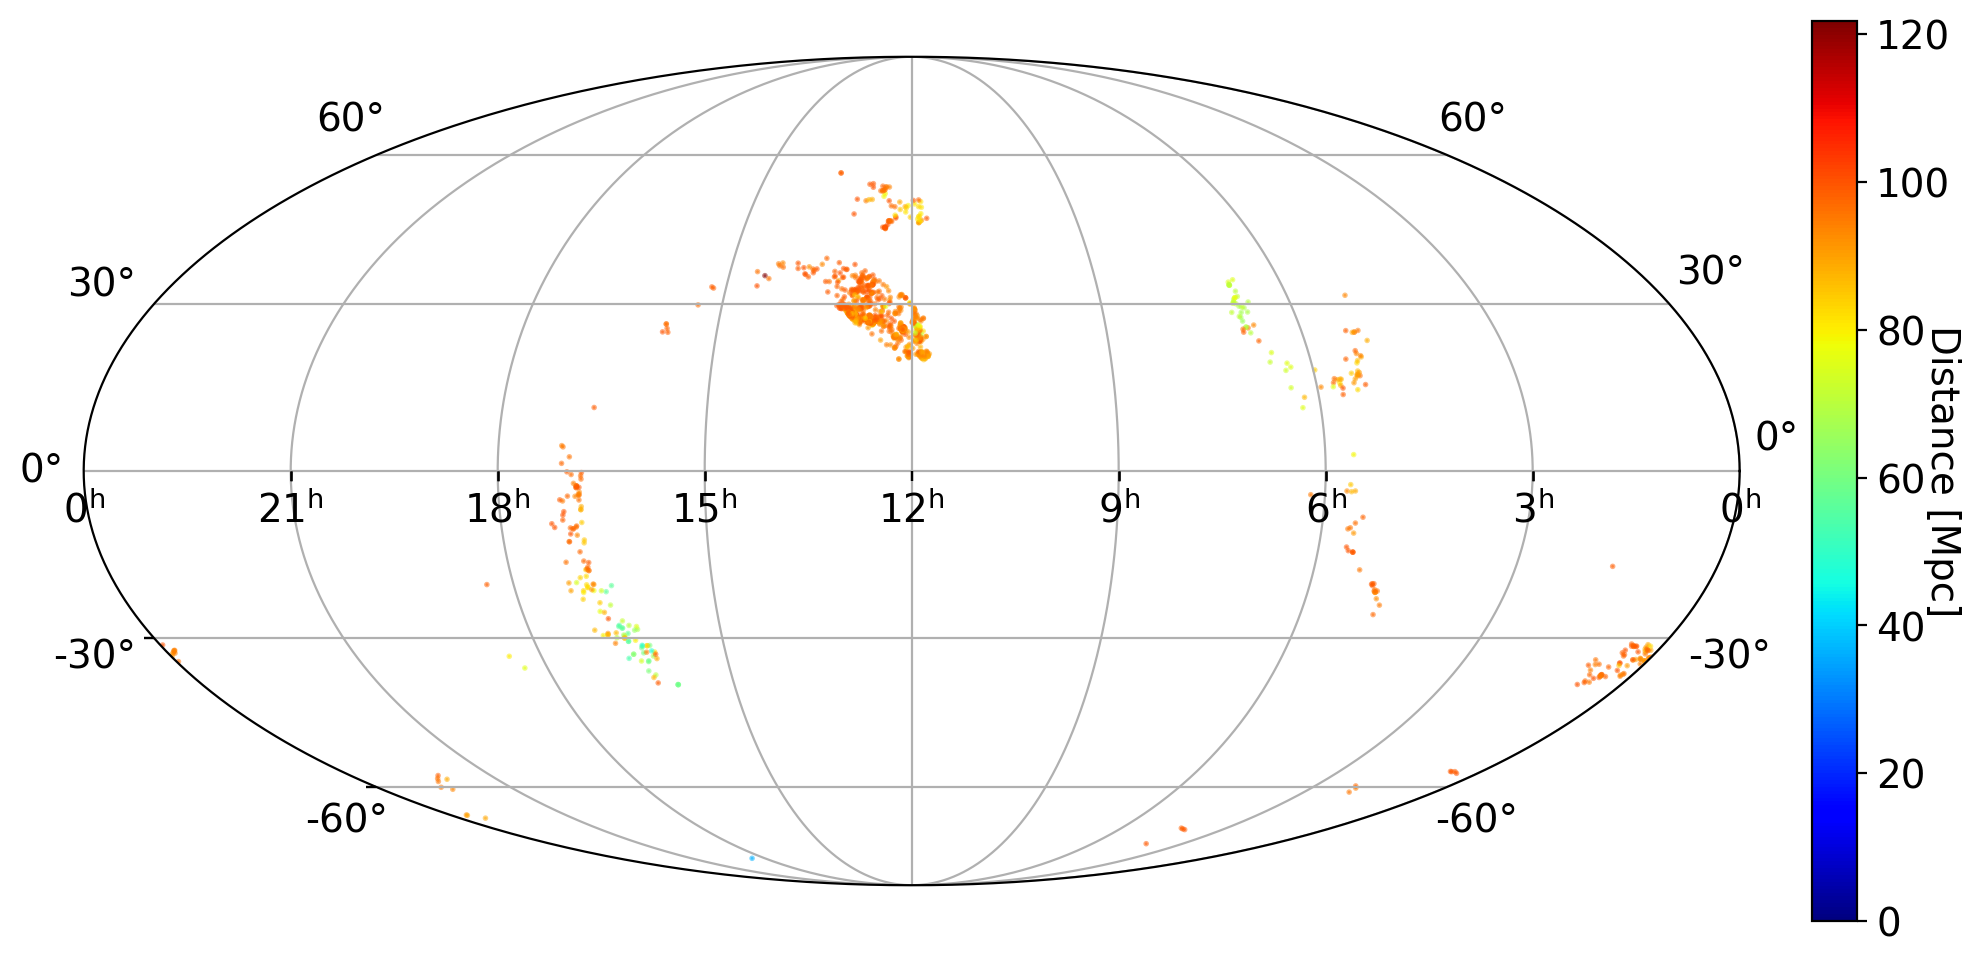

In [45]:
fig = pl.figure(figsize=(10, 5), dpi=200)
prob_cut = 0.5

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro mollweide')

galplot = ax.scatter(
    catalogs[0][result.searched_prob_vol < prob_cut]['RAJ2000'], catalogs[0][result.searched_prob_vol < prob_cut]['DEJ2000'],
    transform=ax.get_transform('world'),
    c=catalogs[0][result.searched_prob_vol < prob_cut]['Dist'], s=1, alpha=0.5, cmap='jet', vmin=0)

cb = pl.colorbar(galplot, fraction=0.04, pad=0.04)
cb.set_alpha(1)
cb.draw_all()
cb.set_label('Distance [Mpc]', rotation=270)

ax.grid()

As can be seen above, the galaxies selected using the distance information are towards the far end of the distance for the catalog, and their distribution is not well covered by the blind tiling we did before where we concentrated on the localization probability alone. 